In [8]:
import boto3
import botocore
import sagemaker
import sys
import numpy as np
import pandas as pd
from sagemaker import RandomCutForest
import matplotlib
import matplotlib.pyplot as plt

s3 = boto3.resource('s3')
bucket = 'big-data-clemson'   # Feel free to change to another bucket you have access to
data_key = 'big_data_train.csv'
execution_role = sagemaker.get_execution_role()
data_location = 's3://{}/{}'.format(bucket, data_key)

In [9]:
train_df = pd.read_csv(data_location)

In [10]:
train_df.head()

,EDT,Air_Temperature
0,1601000346000,17.3
1,1601359945000,21.9
2,1601038173000,16.8
3,1601276764000,20.8
4,1601082369000,18.8


In [11]:
import datetime
train_df['EDT']=(pd.to_datetime(train_df['EDT'],unit='ms'))

In [12]:
train_df['EDT'] = train_df['EDT'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))

In [13]:
train_df.head()

,EDT,Air_Temperature
0,2020-09-25 02:19:06,17.3
1,2020-09-29 06:12:25,21.9
2,2020-09-25 12:49:33,16.8
3,2020-09-28 07:06:04,20.8
4,2020-09-26 01:06:09,18.8


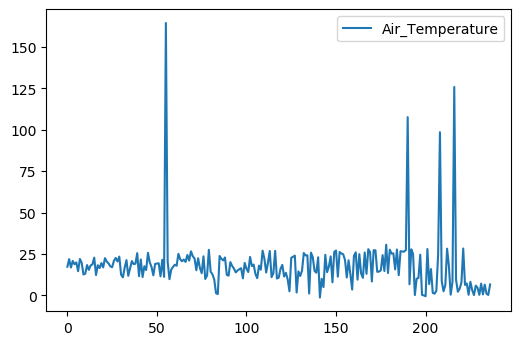

In [14]:

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi'] = 100

train_df.plot()

In [24]:

def convert_and_upload_training_data(ndarray, bucket, filename='train_data.csv'):
    import boto3
    import os
    from sagemaker.amazon.common import numpy_to_record_serializer
    
    # convert numpy array to Protobuf RecordIO format
    serializer = numpy_to_record_serializer()
    buffer = serializer(ndarray)
    
    # Upload to S3
    s3_object = filename
    boto3.Session().resource('s3').Bucket(bucket).Object(s3_object).upload_fileobj(buffer)
    
    s3_path = 's3://{}/{}'.format(bucket, s3_object)
    return s3_path

# RCV only works on an array of values.
s3_train_data = convert_and_upload_training_data(
    train_df['Air_Temperature'].values.reshape(-1,1),
    bucket)
print('Uploaded data to {}'.format(s3_train_data))

Uploaded data to s3://big-data-clemson/train_data.csv


In [31]:
from sagemaker import RandomCutForest

session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(role=execution_role,
                      train_instance_count=1,
                      train_instance_type='ml.m4.xlarge',
                      data_location='s3://{}/'.format(bucket),
                      output_path='s3://{}/output'.format(bucket),
                      num_samples_per_tree=512,
                      num_trees=50)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(train_df['Air_Temperature'].values.reshape(-1,1)))

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-10-03 19:54:20 Starting - Starting the training job...
2020-10-03 19:54:21 Starting - Launching requested ML instances......
2020-10-03 19:55:25 Starting - Preparing the instances for training......
2020-10-03 19:56:22 Downloading - Downloading input data...
2020-10-03 19:56:56 Training - Downloading the training image.Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python2.7/site-packages/scipy/_lib/_numpy_compat.py:10: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing.nosetester import import_nose
/opt/amazon/lib/python2.7/site-packages/scipy/stats/morestats.py:12: DeprecationWarning: Importing from numpy.testing.decorators is deprecated, import from numpy.testing instead.
  from numpy.testing.decorators import setastest
[10/03/2020 19:57:26 INFO 139685348259648] Reading default configuration from /opt/amazon/lib/python2.7/site-packag

In [32]:

rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!

In [33]:
print('Endpoint name: {}'.format(rcf_inference.endpoint))

Endpoint name: randomcutforest-2020-10-03-19-54-20-067


In [34]:
from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'application/json'
rcf_inference.deserializer = json_deserializer

In [38]:
train_df_numpy = train_df['Air_Temperature'].values.reshape(-1,1)
print(train_df_numpy[:6])
results = rcf_inference.predict(train_df_numpy[:6])

[[17.3]
 [21.9]
 [16.8]
 [20.8]
 [18.8]
 [19.9]]


In [41]:
results = rcf_inference.predict(train_df_numpy)
scores = [datum['score'] for datum in results['scores']]

# add scores to taxi data frame and print first few values
train_df['score'] = pd.Series(scores, index=train_df.index)
train_df.head()

,EDT,Air_Temperature,score
0,2020-09-25 02:19:06,17.3,0.833164
1,2020-09-29 06:12:25,21.9,0.828824
2,2020-09-25 12:49:33,16.8,0.848438
3,2020-09-28 07:06:04,20.8,0.818736
4,2020-09-26 01:06:09,18.8,0.829415


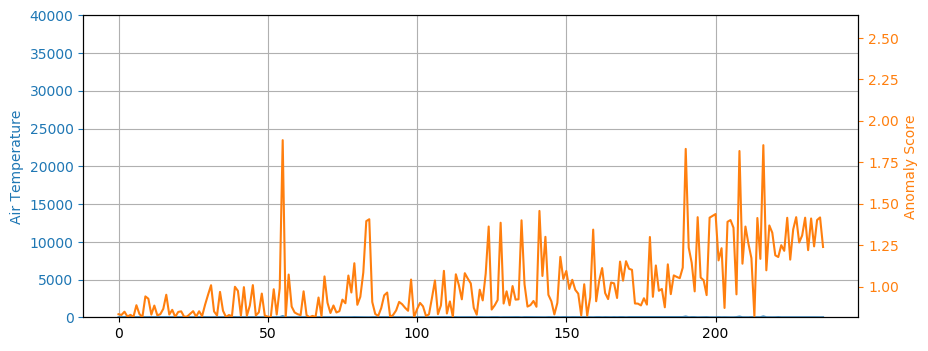

In [44]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#
# *Try this out* - change `start` and `end` to zoom in on the 
# anomaly found earlier in this notebook
#
start, end = 0, len(train_df)
#start, end = 500, 600
train_data_subset = train_df[start:end]

ax1.plot(train_data_subset['Air_Temperature'], color='C0', alpha=0.8)
ax2.plot(train_data_subset['score'], color='C1')

ax1.grid(which='major', axis='both')

ax1.set_ylabel('Air Temperature', color='C0')
ax2.set_ylabel('Anomaly Score', color='C1')

ax1.tick_params('y', colors='C0')
ax2.tick_params('y', colors='C1')

ax1.set_ylim(0, 40000)
ax2.set_ylim(min(scores), 1.4*max(scores))
fig.set_figwidth(10)

In [45]:
score_mean = train_df['score'].mean()
score_std = train_df['score'].std()
score_cutoff = score_mean + 3*score_std

anomalies = train_data_subset[train_data_subset['score'] > score_cutoff]
anomalies

,EDT,Air_Temperature,score
55,2020-09-24 12:23:20,164.40,1.883039
190,2020-09-24 12:34:57,107.60,1.830399
208,2020-09-29 13:16:29,98.49,1.817610
216,2020-09-27 22:04:03,125.80,1.852912


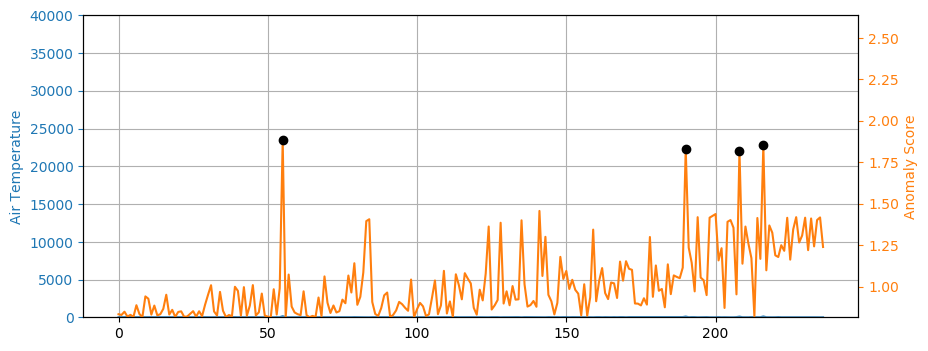

In [46]:
ax2.plot(anomalies.index, anomalies.score, 'ko')
fig

In [47]:
sagemaker.Session().delete_endpoint(rcf_inference.endpoint)